<a href="https://colab.research.google.com/github/GuQiangJS/finance-tools-py/blob/master/jupyters/%E6%8C%87%E6%A0%87%E7%9B%B8%E5%85%B3%E6%80%A7%E6%B5%8B%E8%AF%95_%E5%8F%A0%E5%8A%A0%E6%8C%87%E6%A0%87_DEMA%2BMFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 初步结论

结合 DEMA 和 MFI 以后，交易次数明显减少，套牢也随之减少。DEMA拉长时间段以后可以更加减少套牢。

## 安装思源字体

这样显示好看点。呵呵！

In [0]:
import os
noto_font_path='/usr/share/fonts/NotoSansCJKsc-Medium.otf'
if not os.path.exists(noto_font_path):
    !wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKsc-hinted.zip"
    !unzip "NotoSansCJKsc-hinted.zip"
    !mv NotoSansCJKsc-Medium.otf /usr/share/fonts/
from IPython.display import clear_output
clear_output(True)

## 安装第三方库。

[talib](https://www.fmz.com/bbs-topic/1234)，[finance-tools-py](https://github.com/GuQiangJS/finance-tools-py)

In [0]:
try:
    import talib
except ModuleNotFoundError:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    import talib
try:
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.backtest import BackTest
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import DEMA
    from finance_tools_py.simulation.callbacks.talib import MFI
    from finance_tools_py.simulation.callbacks import Rolling_Future
    from finance_tools_py.backtest import AllInChecker
except ModuleNotFoundError:
    !pip install git+https://github.com/GuQiangJS/finance-tools-py.git -U
    import finance_tools_py
    from finance_tools_py.simulation import Simulation
    from finance_tools_py.backtest import BackTest
    from finance_tools_py.simulation.callbacks import CallBack
    from finance_tools_py.simulation.callbacks.talib import DEMA
    from finance_tools_py.simulation.callbacks.talib import MFI
    from finance_tools_py.simulation.callbacks import Rolling_Future
    from finance_tools_py.backtest import AllInChecker
clear_output(True)

## 其他相关引用

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import datetime
%matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)
plt.style.use('ggplot')

fontprop = matplotlib.font_manager.FontProperties(fname=noto_font_path)
matplotlib.font_manager.fontManager.ttflist += matplotlib.font_manager.createFontList([noto_font_path])
plt.rcParams['font.family'] = fontprop.get_name()

plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

## 读取数据

1. 读取交易日期、开盘价、最高价、最低价、收盘价、成交量。所有数据均取**前复权**数据。

In [0]:
def read_data(symbol='600036'):
    data=pd.read_csv('https://raw.githubusercontent.com/GuQiangJS/temp/master/{}_daily.csv'.format(symbol),parse_dates=True,
                    usecols=['date','open_qfq','high_qfq','low_qfq','close_qfq','volume_qfq'])
    data['date']=pd.to_datetime(data['date'])
    data.rename(columns={'open_qfq':'open','high_qfq':'high','low_qfq':'low','close_qfq':'close','volume_qfq':'volume'},inplace=True)
    data['preclose']=data['close'].shift()
    data['nextclose']=data['close'].shift(-1)
    data['nextchange']=data['nextclose']-data['close']
    data['nextchange_sign']=np.sign(data['nextchange'])
    return data

## 数据处理

计算两条线的上穿和下穿

In [0]:
class Cross_DEMA(CallBack):
    def __init__(self,t1,t2):
        self.t1=t1
        self.t2=t2

    """双线相交法"""
    def on_preparing_data(self, data, **kwargs):
        data['{}日线上穿{}日线'.format(self.t1,self.t2)]=0
        data['{}日线下穿{}日线'.format(self.t1,self.t2)]=0
        #下穿。t1.dema<t2.dema & t1.dema.shift>t2.dema.shift
        data.loc[(data['dema_close_{}'.format(self.t1)]<data['dema_close_{}'.format(self.t2)]) & (data['dema_close_{}'.format(self.t1)].shift()>data['dema_close_{}'.format(self.t2)].shift()),'{}日线下穿{}日线'.format(self.t1,self.t2)]=1
        #上穿。t1.dema>t2.dema & t1.dema.shift<t2.dema.shift
        data.loc[(data['dema_close_{}'.format(self.t1)]>data['dema_close_{}'.format(self.t2)]) & (data['dema_close_{}'.format(self.t1)].shift()<data['dema_close_{}'.format(self.t2)].shift()),'{}日线上穿{}日线'.format(self.t1,self.t2)]=1

class Rolling_Future_New(Rolling_Future):
    def on_preparing_data(self, data, **kwargs):
        super().on_preparing_data(data, **kwargs)
        data['未来{}日涨跌'.format(self.timeperiod)]=np.sign(data['rolling_{}_{}_mean'.format(self.col_name,self.timeperiod)]-data[self.col_name])
        data.rename(columns={'rolling_close_{}_mean/close'.format(self.timeperiod):'未来 {} 日均价/当前'.format(self.timeperiod)},inplace=True)



In [0]:
import plotly.graph_objects as go
def plot(data,x,y,buy=None,sell=None):
    plot_ly(data,x,y,buy,sell).show()
    plot_py(data,x,y,buy,sell)
    plt.show()

def plot_ly(data,x,y,buy=None,sell=None):
    fig = go.Figure()
    for y1 in y:
        fig.add_trace(go.Scatter(x=data[x], y=data[y1],mode='lines',name=y1))
    if buy:
        b=data[data[x].isin(buy)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="red",size=6)))
    if sell:
        b=data[data[x].isin(sell)]
        fig.add_trace(go.Scatter(x=b[x], y=b['close'],mode='markers',marker=dict(color="green",size=6)))
    return fig

def plot_py(data,x,y,buy=None,sell=None):
    fig=plt.figure(figsize=(22,8))
    for y1 in y:
        sns.lineplot(data=data,x=x,y=y1)
    if buy:
        b=data[data[x].isin(buy)]
        plt.plot(b[x], b['close'],'r.')
    if sell:
        b=data[data[x].isin(sell)]
        plt.plot(b[x], b['close'],'gx')
    return fig
    


def test_dema_line_plot(symbol,t1,t2):
    data=read_data(symbol)
    s=Simulation(data,'',callbacks=[DEMA(t1),
                    DEMA(t2),
                    Cross_DEMA(t1,t2)])
    s.simulate()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['close'],mode='lines',name='close'))
    fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t1)],mode='lines',name='{} 日线'.format(t1)))
    fig.add_trace(go.Scatter(x=s.data['date'], y=s.data['dema_close_{}'.format(t2)],mode='lines',name='{} 日线'.format(t2)))

    cross_up=s.data.loc[s.data['{}日线上穿{}日线'.format(t1,t2)]==1]
    cross_low=s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]

    fig.add_trace(go.Scatter(x=cross_up['date'], y=cross_up['close'],mode='markers',marker=dict(color="red",size=6),name='{}日线上穿{}日线'.format(t1,t2)))
    fig.add_trace(go.Scatter(x=cross_low['date'], y=cross_low['close'],mode='markers',marker=dict(color="green",size=6),name='{}日线下穿{}日线'.format(t1,t2)))
    fig.update_layout(title='{}日线 VS {}日线'.format(t1,t2))
    return fig

class Checker(AllInChecker):
    
    def on_calc_buy_amount(self,
                           date: datetime.datetime.timestamp,
                           code: str,
                           price: float,
                           cash: float) -> float:
        # 每次最多买1/5
        return super().on_calc_buy_amount(date,code,price,cash*0.25)

    def on_check_sell(self,
                      date: datetime.datetime.timestamp,
                      code: str,
                      price: float,
                      cash: float,
                      hold_amount: float,
                      hold_price: float) -> bool:
        """当 `date` 及 `code` 包含在参数 :py:attr:`sell_dict` 中时返回 `True` 。否则返回 `False` 。"""
        if hold_amount>0 and hold_price*1.15>price:
            return False
        if code in self.sell_dict.keys() and date in self.sell_dict[code]:
            return True
        else:
            return False

## 三移动平均线

In [0]:
class Cross_DEMA_3(CallBack):
    def __init__(self,t1,t2,t3):
        self.t1=t1
        self.t2=t2
        self.t3=t3

    """三移动平均法"""
    def on_preparing_data(self, data, **kwargs):
        data['均是向下']=0
        data['均是向上']=0

        data.loc[(data['close']<data['dema_close_{}'.format(self.t1)]) &
                 (data['dema_close_{}'.format(self.t1)]<data['dema_close_{}'.format(self.t2)]) &
                 (data['dema_close_{}'.format(self.t2)]<data['dema_close_{}'.format(self.t3)])
                 ,'均是向下']=1
        data.loc[(data['close']>data['dema_close_{}'.format(self.t1)]) &
                 (data['dema_close_{}'.format(self.t1)]>data['dema_close_{}'.format(self.t2)]) &
                 (data['dema_close_{}'.format(self.t2)]>data['dema_close_{}'.format(self.t3)])
                 ,'均是向上']=1

def test_dema_3_cross1(symbol,t1,t2,t3,**kwargs):
    data=read_data(symbol)
    s=Simulation(data,'',callbacks=[DEMA(t1),
                    DEMA(t2),
                    DEMA(t3),
                    Cross_DEMA_3(t1,t2,t3),
                    ])
    s.simulate()
    # s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date'].values
    s.data['code']=symbol

    buy=s.data[(s.data['date']<'2019-01-01') & (s.data['均是向下']==1)]['date']
    sell=s.data[(s.data['date']<'2019-01-01') & (s.data['均是向上']==1)]['date']

    bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
        buy_dict={symbol: buy.dt.to_pydatetime()},
        sell_dict={symbol: sell.dt.to_pydatetime()})])
    bt.calc_trade_history(verbose=0)
    if kwargs.pop('print_report',True):
        print(bt.report(show_history=kwargs.pop('show_history',False)))
    if kwargs.pop('plot',True):
        plot(s.data,x='date',
            y=['close'],
            buy=list(buy.values),
            sell=list(sell.values)
            )
    return bt if bt else None

def test_dema_3_cross2(symbol,t1,t2,t3,mfi_day=14,**kwargs):
    data=read_data(symbol)
    s=Simulation(data,'',callbacks=[DEMA(t1),
                    DEMA(t2),
                    DEMA(t3),
                    MFI(mfi_day),
                    Cross_DEMA_3(t1,t2,t3),
                    ])
    s.simulate()
    # s.data.loc[s.data['{}日线下穿{}日线'.format(t1,t2)]==1]['date'].values
    s.data['code']=symbol

    # sell=s.data[s.data['mfi_{}'.format(day)]>80]['date']
    # buy=s.data[s.data['mfi_{}'.format(day)]<20]['date']

    buy=s.data[(s.data['date']<'2019-01-01') & (s.data['均是向下']==1) & (s.data['mfi_{}'.format(mfi_day)]<20)]['date']
    sell=s.data[(s.data['date']<'2019-01-01') & (s.data['均是向上']==1) & (s.data['mfi_{}'.format(mfi_day)]>80)]['date']

    bt = BackTest(s.data, init_cash=10000, callbacks=[Checker(
        buy_dict={symbol: buy.dt.to_pydatetime()},
        sell_dict={symbol: sell.dt.to_pydatetime()})])
    bt.calc_trade_history(verbose=0)
    if kwargs.pop('print_report',True):
        print(bt.report(show_history=kwargs.pop('show_history',False)))
    if kwargs.pop('plot',True):
        plot(s.data,x='date',
            y=['close'],
            buy=list(buy.values),
            sell=list(sell.values)
            )
    return bt if bt else None

### 5-10-20


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:145 (买入/卖出各算1次)
可用资金:9369.15
当前持仓:        buy_price  amount  price_cur
code                                
600036  29.296809  1800.0      37.58
当前总资产:77013.15(现金+持股现价值)
资金变化率:93.69%
资产变化率:770.13%
总手续费:1088.43
总印花税:752.07



数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:23 (买入/卖出各算1次)
可用资金:15227.37
当前持仓:无
当前总资产:15227.37(现金+持股现价值)
资金变化率:152.27%
资产变化率:152.27%
总手续费:128.55
总印花税:57.40


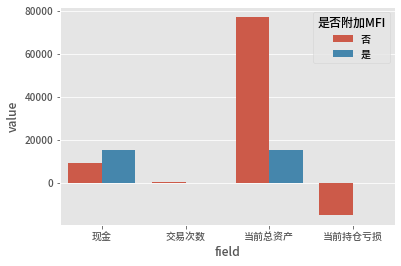

In [59]:
bt1=test_dema_3_cross1('600036',5,10,20,plot=False)
bt2=test_dema_3_cross2('600036',5,10,20,plot=False)

df1=pd.DataFrame({'value':[bt1.available_cash,
                           len(bt1.history_df),
                           bt1.total_assets_cur,
                           sum((bt1.hold_price_cur_df['buy_price']-bt1.hold_price_cur_df['price_cur'])*bt1.hold_price_cur_df['amount']) if not bt1.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['否','否','否','否']})
df2=pd.DataFrame({'value':[bt2.available_cash,
                           len(bt2.history_df),
                           bt2.total_assets_cur,
                           sum((bt2.hold_price_cur_df['buy_price']-bt2.hold_price_cur_df['price_cur'])*bt2.hold_price_cur_df['amount']) if not bt2.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['是','是','是','是']})
df=pd.concat([df1,df2])

sns.barplot(data=df,x='field',y='value',hue='是否附加MFI')


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:233 (买入/卖出各算1次)
可用资金:1619.40
当前持仓:        buy_price   amount  price_cur
code                                 
600858  13.844455  10000.0        4.5
当前总资产:46619.40(现金+持股现价值)
资金变化率:16.19%
资产变化率:466.19%
总手续费:2380.16
总印花税:1838.43



数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:61 (买入/卖出各算1次)
可用资金:11355.10
当前持仓:        buy_price  amount  price_cur
code                                
600858   5.887073  8100.0        4.5
当前总资产:47805.10(现金+持股现价值)
资金变化率:113.55%
资产变化率:478.05%
总手续费:502.76
总印花税:414.34


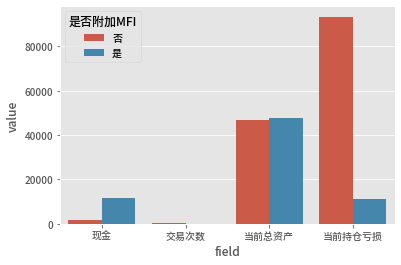

In [60]:
bt1=test_dema_3_cross1('600858',5,10,20,plot=False)
bt2=test_dema_3_cross2('600858',5,10,20,plot=False)

df1=pd.DataFrame({'value':[bt1.available_cash,
                           len(bt1.history_df),
                           bt1.total_assets_cur,
                           sum((bt1.hold_price_cur_df['buy_price']-bt1.hold_price_cur_df['price_cur'])*bt1.hold_price_cur_df['amount']) if not bt1.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['否','否','否','否']})
df2=pd.DataFrame({'value':[bt2.available_cash,
                           len(bt2.history_df),
                           bt2.total_assets_cur,
                           sum((bt2.hold_price_cur_df['buy_price']-bt2.hold_price_cur_df['price_cur'])*bt2.hold_price_cur_df['amount']) if not bt2.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['是','是','是','是']})
df=pd.concat([df1,df2])

sns.barplot(data=df,x='field',y='value',hue='是否附加MFI')

### 10-30-120


数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:53 (买入/卖出各算1次)
可用资金:7351.18
当前持仓:        buy_price  amount  price_cur
code                                
600036  28.027864   600.0      37.58
当前总资产:29899.18(现金+持股现价值)
资金变化率:73.51%
资产变化率:298.99%
总手续费:319.97
总印花税:179.85



数据时间:2002-04-09 00:00:00~2019-12-31 00:00:00（可交易天数4236）
初始资金:10000.00
交易次数:26 (买入/卖出各算1次)
可用资金:8144.76
当前持仓:        buy_price  amount  price_cur
code                                
600036  24.536921   300.0      37.58
当前总资产:19418.76(现金+持股现价值)
资金变化率:81.45%
资产变化率:194.19%
总手续费:143.50
总印花税:58.65


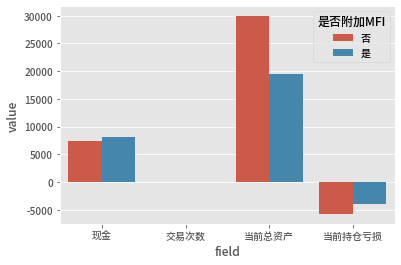

In [61]:
bt1=test_dema_3_cross1('600036',10,30,120,plot=False)
bt2=test_dema_3_cross2('600036',10,30,120,plot=False)

df1=pd.DataFrame({'value':[bt1.available_cash,
                           len(bt1.history_df),
                           bt1.total_assets_cur,
                           sum((bt1.hold_price_cur_df['buy_price']-bt1.hold_price_cur_df['price_cur'])*bt1.hold_price_cur_df['amount']) if not bt1.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['否','否','否','否']})
df2=pd.DataFrame({'value':[bt2.available_cash,
                           len(bt2.history_df),
                           bt2.total_assets_cur,
                           sum((bt2.hold_price_cur_df['buy_price']-bt2.hold_price_cur_df['price_cur'])*bt2.hold_price_cur_df['amount']) if not bt2.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['是','是','是','是']})
df=pd.concat([df1,df2])

sns.barplot(data=df,x='field',y='value',hue='是否附加MFI')


数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:282 (买入/卖出各算1次)
可用资金:1573.75
当前持仓:        buy_price   amount  price_cur
code                                 
600858    9.42837  30200.0        4.5
当前总资产:137473.75(现金+持股现价值)
资金变化率:15.74%
资产变化率:1374.74%
总手续费:4113.26
总印花税:3483.06



数据时间:1994-05-06 00:00:00~2020-03-09 00:00:00（可交易天数5860）
初始资金:10000.00
交易次数:72 (买入/卖出各算1次)
可用资金:5001.51
当前持仓:        buy_price  amount  price_cur
code                                
600858   5.987093  6100.0        4.5
当前总资产:32451.51(现金+持股现价值)
资金变化率:50.02%
资产变化率:324.52%
总手续费:480.52
总印花税:311.22


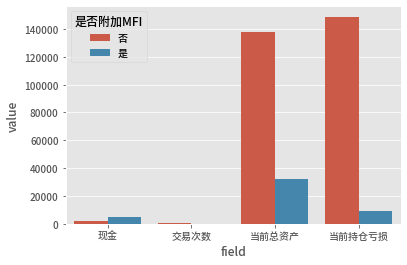

In [62]:
bt1=test_dema_3_cross1('600858',10,30,120,plot=False)
bt2=test_dema_3_cross2('600858',10,30,120,plot=False)

df1=pd.DataFrame({'value':[bt1.available_cash,
                           len(bt1.history_df),
                           bt1.total_assets_cur,
                           sum((bt1.hold_price_cur_df['buy_price']-bt1.hold_price_cur_df['price_cur'])*bt1.hold_price_cur_df['amount']) if not bt1.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['否','否','否','否']})
df2=pd.DataFrame({'value':[bt2.available_cash,
                           len(bt2.history_df),
                           bt2.total_assets_cur,
                           sum((bt2.hold_price_cur_df['buy_price']-bt2.hold_price_cur_df['price_cur'])*bt2.hold_price_cur_df['amount']) if not bt2.hold_price_cur_df.empty else 0,
                           ],
                  'field':['现金','交易次数','当前总资产','当前持仓亏损'],
                  '是否附加MFI':['是','是','是','是']})
df=pd.concat([df1,df2])

sns.barplot(data=df,x='field',y='value',hue='是否附加MFI')